In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as s
import scipy.special as ss
import sortedcontainers as sc
import os

In [2]:
import tqdm

In [3]:
os.environ["CAPY_REF_FA"] = "/Users/opriebe/dev/mutsig3/GRCh38.d1.vd1.fa"
import hapaseg.coverage_MCMC as mcmc_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


Load MCMC trace over SNP DP cluster assignments. Still looking at only the high purity exome

In [4]:
colors = mpl.cm.get_cmap("tab10").colors

### Load coverage

In [5]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [6]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [7]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [8]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

### load SNPs

In [9]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[:, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prone improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [10]:
#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap.copy()

In [11]:
#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

In [12]:
Cov_overlap = Cov_overlap.iloc[~naidx]

In [13]:
#strategy: make B - 1 breakpoints for B bins but do not allow breakpoints between chromosomes to be picked
cov_breaks = sc.SortedSet(np.r_[:len(Cov_overlap)])
_ = [cov_breaks.discard(elt) for elt in Cov_overlap.groupby('chr').size().cumsum().values -1]

In [14]:
# pick random breakpoint
break_pick = cov_breaks[np.random.choice(len(cov_breaks))]

In [15]:
mu = np.log(r.mean()*np.ones([Pi.shape[1], 1]))
beta = np.ones([C.shape[1], 1])
mu_i = np.zeros(C.shape[0])

## Define optimization functions

In [16]:
# mu gradient
def gradmu(mu, beta, r, C, Pi, mu_i):
    e = np.exp(C@beta + Pi@mu + mu_i[:, None])
    return Pi.T@(r - e)

# mu Hessian
def hessmu(mu, beta, r, C, Pi, mu_i): 
    e = np.exp(C@beta + Pi@mu + mu_i[:, None])
    return -Pi.T@np.diag(e.ravel())@Pi

# beta gradient
def gradbeta(beta, mu, r, C, Pi, mu_i):
    e = np.exp(C@beta + Pi@mu + mu_i[:, None])
    return C.T@(r - e)

# beta Hessian
def hessbeta(beta, mu, r, C, Pi, mu_i): 
    e = np.exp(C@beta + Pi@mu + mu_i[:, None])
    return -C.T@np.diag(e.ravel())@C

# mu,beta Hessian
def hessmubeta(mu, beta, r, C, Pi, mu_i):
    e = np.exp(C@beta + Pi@mu + mu_i[:, None])
    return -C.T@np.diag(e.ravel())@Pi

# join mu gradient
def joingradmu(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r):
    #ind_l and ind_r are (st, end) index tuples for the intervals contained in the left and right segments to join
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_share)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_share)

    e_outer_l = np.exp(C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None])
    e_outer_r = np.exp(C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None])

    grad_l = Pi[ind_l[0]:ind_l[1]].T@(r[ind_l[0]:ind_l[1]] - e_l)
    grad_r = Pi[ind_r[0]:ind_r[1]].T@(r[ind_r[0]:ind_r[1]] - e_r)

    grad_outer_l = Pi[:ind_l[0]].T@(r[:ind_l[0]] - e_outer_l)
    grad_outer_r = Pi[ind_r[1]:].T@(r[ind_r[1]:] - e_outer_r)
    return grad_l + grad_r + grad_outer_l + grad_outer_r

#join beta gradient
def joingradbeta(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_share)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_share)

    e_outer_l = np.exp(C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None])
    e_outer_r = np.exp(C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None])

    grad_l = C[ind_l[0]:ind_l[1]].T@(r[ind_l[0]:ind_l[1]] - e_l)
    grad_r = C[ind_r[0]:ind_r[1]].T@(r[ind_r[0]:ind_r[1]] - e_r)

    grad_outer_l = C[:ind_l[0]].T@(r[:ind_l[0]] - e_outer_l)
    grad_outer_r = C[ind_r[1]:].T@(r[ind_r[1]:] - e_outer_r)
    return grad_l + grad_r + grad_outer_l + grad_outer_r

#join mu_shared gradient
def joingradmu_shared(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_share)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_share)
    
    grad_l = r[ind_l[0]:ind_l[1]] - e_l
    grad_r = r[ind_r[0]:ind_r[1]] - e_r
    return (grad_l.sum() + grad_r.sum())[None,None]

#join mu hessian
def joinhessmu(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_share)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_share)

    e_outer_l = np.exp(C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None])
    e_outer_r = np.exp(C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None])
    
    hess_l = -Pi[ind_l[0]:ind_l[1]].T@np.diag(e_l.ravel())@Pi[ind_l[0]:ind_l[1]]
    hess_r = -Pi[ind_r[0]:ind_r[1]].T@np.diag(e_r.ravel())@Pi[ind_r[0]:ind_r[1]]
    
    hess_outer_l = -Pi[:ind_l[0]].T@np.diag(e_outer_l.ravel())@Pi[:ind_l[0]]
    hess_outer_r = -Pi[ind_r[1]:].T@np.diag(e_outer_r.ravel())@Pi[ind_r[1]:]
    
    return hess_l + hess_r + hess_outer_l + hess_outer_r

def joinhessbeta(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_share)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_share)

    e_outer_l = np.exp(C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None])
    e_outer_r = np.exp(C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None])
    
    hess_l = -C[ind_l[0]:ind_l[1]].T@np.diag(e_l.ravel())@C[ind_l[0]:ind_l[1]]
    hess_r = -C[ind_r[0]:ind_r[1]].T@np.diag(e_r.ravel())@C[ind_r[0]:ind_r[1]]
    
    hess_outer_l = -C[:ind_l[0]].T@np.diag(e_outer_l.ravel())@C[:ind_l[0]]
    hess_outer_r = -C[ind_r[1]:].T@np.diag(e_outer_r.ravel())@C[ind_r[1]:]
    
    return hess_l + hess_r + hess_outer_l + hess_outer_r

def joinhessmubeta(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_share)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_share)

    e_outer_l = np.exp(C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None])
    e_outer_r = np.exp(C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None])
    
    hess_l = -C[ind_l[0]:ind_l[1]].T@np.diag(e_l.ravel())@Pi[ind_l[0]:ind_l[1]]
    hess_r = -C[ind_r[0]:ind_r[1]].T@np.diag(e_r.ravel())@Pi[ind_r[0]:ind_r[1]]
    
    hess_outer_l = -C[:ind_l[0]].T@np.diag(e_outer_l.ravel())@Pi[:ind_l[0]]
    hess_outer_r = -C[ind_r[1]:].T@np.diag(e_outer_r.ravel())@Pi[ind_r[1]:]
    
    return hess_l + hess_r + hess_outer_l + hess_outer_r

def joinhessmumu_shared(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_share)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_share)

    hess_l = -Pi[ind_l[0]:ind_l[1]].T@e_l * mu_share
    hess_r = - Pi[ind_r[0]:ind_r[1]].T@e_r * mu_share
    return hess_l + hess_r

def joinhessbetamu_shared(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_share)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_share)

    hess_l = -C[ind_l[0]:ind_l[1]].T@e_l * mu_share
    hess_r = -C[ind_r[0]:ind_r[1]].T@e_r * mu_share
    return hess_l + hess_r

def joinhessmu_shared(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_share)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_share)
    
    return (-e_l.sum() - e_r.sum())[None,None]

################## split methods ###############
def splitgradmu(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    #ind_l and ind_r are (st, end) index tuples for the intervals contained in the left and right segments to split
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_l)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_r)

    e_outer_l = np.exp(C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None])
    e_outer_r = np.exp(C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None])

    grad_l = Pi[ind_l[0]:ind_l[1]].T@(r[ind_l[0]:ind_l[1]] - e_l)
    grad_r = Pi[ind_r[0]:ind_r[1]].T@(r[ind_r[0]:ind_r[1]] - e_r)

    grad_outer_l = Pi[:ind_l[0]].T@(r[:ind_l[0]] - e_outer_l)
    grad_outer_r = Pi[ind_r[1]:].T@(r[ind_r[1]:] - e_outer_r)
    return grad_l + grad_r + grad_outer_l + grad_outer_r

def splitgradbeta(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_l)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_r)

    e_outer_l = np.exp(C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None])
    e_outer_r = np.exp(C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None])

    grad_l = C[ind_l[0]:ind_l[1]].T@(r[ind_l[0]:ind_l[1]] - e_l)
    grad_r = C[ind_r[0]:ind_r[1]].T@(r[ind_r[0]:ind_r[1]] - e_r)

    grad_outer_l = C[:ind_l[0]].T@(r[:ind_l[0]] - e_outer_l)
    grad_outer_r = C[ind_r[1]:].T@(r[ind_r[1]:] - e_outer_r)
    return grad_l + grad_r + grad_outer_l + grad_outer_r

def splitgradmu_l(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_l)
    
    grad_l = r[ind_l[0]:ind_l[1]] - e_l
    return grad_l.sum()[None,None]

def splitgradmu_r(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_r)
    
    grad_r = r[ind_r[0]:ind_r[1]] - e_r
    return grad_r.sum()[None,None]

def splithessmu(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_l)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_r)

    e_outer_l = np.exp(C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None])
    e_outer_r = np.exp(C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None])
    
    hess_l = -Pi[ind_l[0]:ind_l[1]].T@np.diag(e_l.ravel())@Pi[ind_l[0]:ind_l[1]]
    hess_r = -Pi[ind_r[0]:ind_r[1]].T@np.diag(e_r.ravel())@Pi[ind_r[0]:ind_r[1]]
    
    hess_outer_l = -Pi[:ind_l[0]].T@np.diag(e_outer_l.ravel())@Pi[:ind_l[0]]
    hess_outer_r = -Pi[ind_r[1]:].T@np.diag(e_outer_r.ravel())@Pi[ind_r[1]:]
    
    return hess_l + hess_r + hess_outer_l + hess_outer_r

def splithessbeta(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_l)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_r)

    e_outer_l = np.exp(C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None])
    e_outer_r = np.exp(C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None])
    
    hess_l = -C[ind_l[0]:ind_l[1]].T@np.diag(e_l.ravel())@C[ind_l[0]:ind_l[1]]
    hess_r = -C[ind_r[0]:ind_r[1]].T@np.diag(e_r.ravel())@C[ind_r[0]:ind_r[1]]
    
    hess_outer_l = -C[:ind_l[0]].T@np.diag(e_outer_l.ravel())@C[:ind_l[0]]
    hess_outer_r = -C[ind_r[1]:].T@np.diag(e_outer_r.ravel())@C[ind_r[1]:]
    
    return hess_l + hess_r + hess_outer_l + hess_outer_r

def splithessmu_l(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_l)

    return (-e_l).sum()[None,None]

def splithessmu_r(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_r)

    return (-e_r).sum()[None,None]

def splithessmubeta(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_l)
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_r)

    e_outer_l = np.exp(C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None])
    e_outer_r = np.exp(C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None])
    
    hess_l = -C[ind_l[0]:ind_l[1]].T@np.diag(e_l.ravel())@Pi[ind_l[0]:ind_l[1]]
    hess_r = -C[ind_r[0]:ind_r[1]].T@np.diag(e_r.ravel())@Pi[ind_r[0]:ind_r[1]]
    
    hess_outer_l = -C[:ind_l[0]].T@np.diag(e_outer_l.ravel())@Pi[:ind_l[0]]
    hess_outer_r = -C[ind_r[1]:].T@np.diag(e_outer_r.ravel())@Pi[ind_r[1]:]
    
    return hess_l + hess_r + hess_outer_l + hess_outer_r

def splithessmumu_l(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_l)

    hess_l = -Pi[ind_l[0]:ind_l[1]].T@e_l * mu_l
    return hess_l

def splithessmumu_r(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_r)

    hess_r = - Pi[ind_r[0]:ind_r[1]].T@e_r * mu_r
    return hess_r

def splithessbetamu_l(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_l = np.exp(C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_l)

    hess_l = -C[ind_l[0]:ind_l[1]].T@e_l * mu_l
    return hess_l

def splithessbetamu_r(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r):
    e_r = np.exp(C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_r)

    hess_r = -C[ind_r[0]:ind_r[1]].T@e_r * mu_r
    return hess_r

def splithessmu_lr(*args):
    return np.array(0)[None,None]

In [17]:
# join newton-raphson
def NR_join(mu_0, beta_0, mu_share_0, r, C, Pi, mu_i, ind_l, ind_r, ret_hess = False):
    mu = mu_0.copy()
    beta = beta_0.copy()
    mu_share = mu_share_0
    
    for i in range(100):
        #print(mu, beta, mu_share)
        gmu = joingradmu(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)
        gbeta = joingradbeta(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)
        gmu_share = joingradmu_shared(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)
        grad = np.r_[gmu, gbeta, gmu_share]

        hmu = joinhessmu(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)
        hbeta = joinhessbeta(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)
        hmubeta = joinhessmubeta(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)
        hmu_shared = joinhessmu_shared(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)
        hmumu_shared = joinhessmumu_shared(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)
        hbetamu_shared = joinhessbetamu_shared(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)
        H = np.r_[np.c_[hmu, hmubeta.T, hmumu_shared], np.c_[hmubeta, hbeta, hbetamu_shared], np.c_[hmumu_shared.T, hbetamu_shared.T, hmu_shared]]

        delta = np.linalg.inv(H)@grad
        mu -= delta[0:len(mu)]
        beta -= delta[len(mu):-1]
        mu_share -= delta[-1]

        if np.linalg.norm(grad) < 1e-5:
            break
    if ret_hess:
        return mu, beta, mu_share, H
    else:
        return mu, beta, mu_share

In [18]:
# split newton-raphson
def NR_split(mu_0, beta_0, mu_l_0, mu_r_0, r, C, Pi, mu_i, ind_l, ind_r, ret_hess = False):
    mu = mu_0.copy()
    beta = beta_0.copy()
    mu_l = mu_l_0
    mu_r = mu_r_0
    
    for i in range(100):
        #print(mu, beta, mu_l, mu_r)
        gmu = splitgradmu(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        gbeta = splitgradbeta(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        gmu_l = splitgradmu_l(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        gmu_r = splitgradmu_r(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        grad = np.r_[gmu, gbeta, gmu_l, gmu_l]

        hmu = splithessmu(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        hbeta = splithessbeta(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        hmubeta = splithessmubeta(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        hmu_l = splithessmu_l(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        hmu_r = splithessmu_r(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        hmumu_l = splithessmumu_l(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        hmumu_r = splithessmumu_r(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        hbetamu_l = splithessbetamu_l(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        hbetamu_r = splithessbetamu_r(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        hmu_lr = splithessmu_lr(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)

        H = np.r_[np.c_[hmu, hmubeta.T, hmumu_l, hmumu_r], np.c_[hmubeta, hbeta, hbetamu_l, hbetamu_r], np.c_[hmumu_l.T, hbetamu_l.T, hmu_l, hmu_lr], np.c_[hmumu_r.T, hbetamu_r.T, hmu_lr, hmu_r]]

        delta = np.linalg.inv(H)@grad
        mu -= delta[0:len(mu)]
        beta -= delta[len(mu):-2]
        mu_l -= delta[-2]
        mu_r -= delta[-1]

        if np.linalg.norm(grad) < 1e-5:
            break
    if ret_hess:
        return mu, beta, mu_l, mu_r, H
    else:
        return mu, beta, mu_l, mu_r

In [19]:
# split newton-raphson
def NR_split(mu, beta, mu_l_0, mu_r_0, r, C, Pi, mu_i, ind_l, ind_r, ret_hess = False):
    mu_l = mu_l_0
    mu_r = mu_r_0
    
    for i in range(100):
        #print(mu, beta, mu_l, mu_r)
        gmu_l = splitgradmu_l(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        gmu_r = splitgradmu_r(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        grad = np.r_[gmu_l, gmu_l]

        hmu_l = splithessmu_l(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)
        hmu_r = splithessmu_r(mu, beta, r, C, Pi, mu_i, mu_l, mu_r, ind_l, ind_r)

        H = np.r_[np.c_[hmu_l, 0], np.c_[0,hmu_r]]

        delta = np.linalg.inv(H)@grad
        mu_l -= delta[0]
        mu_r -= delta[1]

        if np.linalg.norm(grad) < 1e-5:
            break
    if ret_hess:
        return mu_l, mu_r, H
    else:
        return mu_l, mu_r

In [20]:
# join newton-raphson
def NR_join(mu, beta, mu_share_0, r, C, Pi, mu_i, ind_l, ind_r, ret_hess = False):
    mu_share = mu_share_0
    
    for i in range(100):
        gmu_shared = joingradmu_shared(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)
        hmu_shared = joinhessmu_shared(mu, beta, r, C, Pi, mu_i, mu_share, ind_l, ind_r)

        delta = gmu_shared / hmu_shared
        mu_share -= delta

        if delta < 1e-5:
            break
    if ret_hess:
        return mu_share, hmu_shared
    else:
        return mu_share

In [21]:
def NR_simp(mu_0, beta_0, r, C, Pi, mu_i):
    mu = mu_0.copy()
    beta = beta_0.copy()
    
    for i in range(100):
        gmu = gradmu(mu, beta, r, C, Pi, mu_i)
        gbeta = gradbeta(beta, mu, r, C, Pi, mu_i)
        grad = np.r_[gmu, gbeta]

        hmu = hessmu(mu, beta, r, C, Pi, mu_i)
        hbeta = hessbeta(beta, mu, r, C, Pi, mu_i)
        hmubeta = hessmubeta(mu, beta, r, C, Pi, mu_i)
        H = np.r_[np.c_[hmu, hmubeta.T], np.c_[hmubeta, hbeta]]

        delta = np.linalg.inv(H)@grad
        mu -= delta[0:len(mu)]
        beta -= delta[len(mu):]

        if np.linalg.norm(grad) < 1e-5:
            break
    return mu, beta

In [22]:
def logp_join(mu_opt, beta_opt, r, C, Pi, mu_i, l_ind, r_ind):
    mu_share, h_join = NR_join(mu_opt, beta_opt, 0, r, C, Pi, mu_i, l_ind, r_ind, True)
    mu_l, mu_r , h_split= NR_split(mu_opt, beta_opt, 0, 0, r, C, Pi, mu_i, l_ind, r_ind, True)

    logprod_j = np.log((2 * np.pi)**(h_join.shape[0] / 2) * (1 / np.sqrt(np.linalg.det(-h_join))))
    logprod_s = np.log((2 * np.pi)**(h_split.shape[0] / 2) * (1 / np.sqrt(np.linalg.det(-h_split))))

    ll_s = split_log_liklihood(mu_opt, beta_opt, mu_l, mu_r, r, C, Pi, mu_i, l_ind, r_ind)
    ll_j = join_log_liklihood(mu_opt, beta_opt, mu_share, r, C, Pi, mu_i, l_ind, r_ind)

    log_marg_ratio = ll_j + logprod_j - LSE(ll_j + logprod_j, ll_s + logprod_s)
    return log_marg_ratio

In [23]:
def log_join_marg_ratio(mu_opt, beta_opt, r, C, Pi, mu_i, l_ind, r_ind):
    mu_share, h_join = NR_join(mu_opt, beta_opt, 0, r, C, Pi, mu_i, l_ind, r_ind, True)
    mu_l, mu_r , h_split= NR_split(mu_opt, beta_opt, 0, 0, r, C, Pi, mu_i, l_ind, r_ind, True)

    logprod_j = np.log((2 * np.pi)**(h_join.shape[0] / 2) * (1 / np.sqrt(np.linalg.det(-h_join))))
    logprod_s = np.log((2 * np.pi)**(h_split.shape[0] / 2) * (1 / np.sqrt(np.linalg.det(-h_split))))

    ll_s = split_log_liklihood(mu_opt, beta_opt, mu_l, mu_r, r, C, Pi, mu_i, l_ind, r_ind)
    ll_j = join_log_liklihood(mu_opt, beta_opt, mu_share, r, C, Pi, mu_i, l_ind, r_ind)

    log_marg_ratio = ll_j + logprod_j - (ll_s + logprod_s)
    return log_marg_ratio

In [24]:
def LSE(x, y):
    lmax = max(x, y)
    return lmax + np.log(np.exp(x - lmax) + np.exp(y - lmax))

In [25]:
def split_log_liklihood(mu, beta, mu_l, mu_r, r, C, Pi, mu_i, ind_l, ind_r):
    l_tmp = C[ind_l[0]:ind_l[1]]@beta + Pi[ind_l[0]:ind_l[1]] @ mu + mu_l
    r_tmp = C[ind_r[0]:ind_r[1]]@beta + Pi[ind_r[0]:ind_r[1]] @ mu + mu_r
    outer_l = C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None]
    outer_r = C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None]
    e_l = np.exp(l_tmp)
    e_r = np.exp(r_tmp)
    e_outer_l = np.exp(outer_l)
    e_outer_r = np.exp(outer_r)
    
    r_sum = r[ind_l[0]:ind_l[1]].T @ l_tmp - e_l.sum() - ss.gammaln(r[ind_l[0]:ind_l[1]]).sum()
    l_sum = r[ind_r[0]:ind_r[1]].T @ r_tmp - e_r.sum() - ss.gammaln(r[ind_r[0]:ind_r[1]]).sum()
    outer_sum_l = r[:ind_l[0]].T @ outer_l - e_outer_l.sum() - ss.gammaln(r[:ind_l[0]]).sum()
    outer_sum_r = r[ind_r[1]:].T @ outer_r - e_outer_r.sum() - ss.gammaln(r[ind_r[1]:]).sum()
    return l_sum + r_sum + outer_sum_l + outer_sum_r
    
def join_log_liklihood(mu, beta, mu_shared, r, C, Pi, mu_i, ind_l, ind_r):
    joined = C[ind_l[0]:ind_r[1]]@beta + Pi[ind_l[0]:ind_r[1]] @ mu + mu_shared
    outer_l = C[:ind_l[0]]@beta + Pi[:ind_l[0]] @ mu + mu_i[:ind_l[0], None]
    outer_r = C[ind_r[1]:]@beta + Pi[ind_r[1]:] @ mu + mu_i[ind_r[1]:, None]
    
    e_joined = np.exp(joined)
    e_outer_l = np.exp(outer_l)
    e_outer_r = np.exp(outer_r)
    
    joined_sum = r[ind_l[0]:ind_r[1]].T @ joined - e_joined.sum() - ss.gammaln(r[ind_l[0]:ind_r[1]]).sum()
    outer_sum_l = r[:ind_l[0]].T @ outer_l - e_outer_l.sum() - ss.gammaln(r[:ind_l[0]]).sum()
    outer_sum_r = r[ind_r[1]:].T @ outer_r - e_outer_r.sum() - ss.gammaln(r[ind_r[1]:]).sum()
    return joined_sum + outer_sum_l + outer_sum_r

def laplace_approx():
    pass

save the mu_i value for each of the segments

at each step we chose a breakpoint, which is either within a segment (meaning the the two adjacent intervals defining it have been joined)(case a) or is not (case b).

case a: we want to consider the two segments S_l and S_r that would be formed if the segment was split.

case b: we want to conider the two adjacent currently existing segments

necessary structures:
- segmentID field in the Cov df, which is initialized to row num and represents the index in the df of the segment's leftmost member
- seg_len dictionary that maps each segID to the number of bins spanned by it (can later default to 1 if not in dictionary)
- interval mu field in cov df (or seperate numpy array)
- state of interval assignment sin the nth iteration
- some sorted dict of precomputed derivative/hessian values (maybe just the exponent?)

procedure:
- each coverage bin has its own segmentID field, which is initialized to its row num
- whenever we consider a breakpoint we look at the two adjacent bins to determine whether they are in the same segment.
- if we pick a breakpoint between two singleton intervals we compute marginal likelihoods and decide to join, which would result in setting their two segmentIDs to its leftmost member (i.e. lower index). We also update the mu_i dictionary (segmentID -> mu_i) to contain its shared optimal value while also discarding their old mu_i values (zeros)
- if we pick a breakpoint between a segment and a singleton we can find the indices of each using its segmentID and the segmentID -> segment_len dictionary. and the mu_i values for each from the mu_i dictionary 
                    

In [27]:
mcmc_C = mcmc_cov.Cov_MCMC(r, C, Pi, Cov_overlap)

In [31]:
mcmc_C.run(50000)

100%|██████████████████████████████████████████████████████████████████████████████████| 50000/50000 [05:07<00:00, 162.73it/s]


In [34]:
len(mcmc_C.full_liklihood)

60000

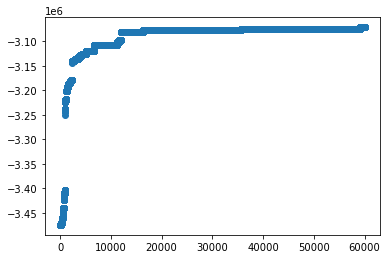

In [35]:
plt.scatter(np.r_[0:60000], mcmc_C.full_liklihood)

(array([0.97349643, 0.02650357, 0.        , 0.        , 0.        ,
        0.        ]),
 array([1, 2, 3, 4, 5, 6, 7]),
 <BarContainer object of 6 artists>)

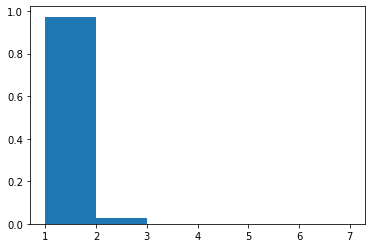

In [36]:
plt.hist(mcmc_C.segLenDict.values(), bins = np.r_[1:8], density=True)

In [40]:
mcmc_C.mu_i[np.nonzero(mcmc_C.mu_i)]

array([-0.05017115, -0.05017115,  0.32442825,  0.3120303 , -0.02342718,
       -0.02342718, -0.03360359, -0.03360359, -0.07256584, -0.07256584,
       -0.25835111, -0.23373699, -0.00582655,  0.00177723,  0.07603884,
        0.09256667, -0.20894564, -0.18795099,  0.06811059,  0.0770963 ,
       -0.29462692, -0.31534354, -0.10243773, -0.07311359, -0.16201941,
       -0.19194371, -0.25513076, -0.22522556,  0.09463865,  0.09463865,
        0.08739695,  0.10010778, -0.15883355, -0.17639612, -0.17288907,
       -0.17288907, -0.19202464, -0.19202464, -0.22041203, -0.22303409,
       -0.15886682, -0.14138951, -0.01130325, -0.01216093, -0.05340628,
       -0.0633237 , -0.13132528, -0.13132528, -0.21122973, -0.21800133,
       -0.22408629, -0.22408629, -0.10842679, -0.10842679, -0.08738638,
       -0.2706337 , -0.294054  , -0.39743131, -0.41371074, -0.17034873,
       -0.1542059 , -0.01454251, -0.03203555, -0.15057778, -0.16309674,
       -0.17000294, -0.18780551,  0.24845156,  0.22774183,  0.00

In [43]:
Cov_overlap["next_g"] = np.r_[Cov_overlap.iloc[1:]["start_g"], 2880794554]

In [44]:
min_tots = np.zeros(clust_uj.max() + 1)
maj_tots = np.zeros(clust_uj.max() + 1)
for clusts, phases in zip(clust_uj, clust["snps_to_phases"]):
    # reset phases
    SNPs2 = SNPs.copy()
    SNPs2.iloc[phases, [0, 1]] = SNPs2.iloc[phases, [1, 0]]

    maj_tots += npg.aggregate(clusts, SNPs2["maj"], size = clust_uj.max() + 1)
    min_tots += npg.aggregate(clusts, SNPs2["min"], size = clust_uj.max() + 1)

min_tots /= clust_uj.shape[0]
maj_tots /= clust_uj.shape[0]

In [45]:
f_prune = (min_tots/(min_tots + maj_tots))[np.flatnonzero(prune_idx)]

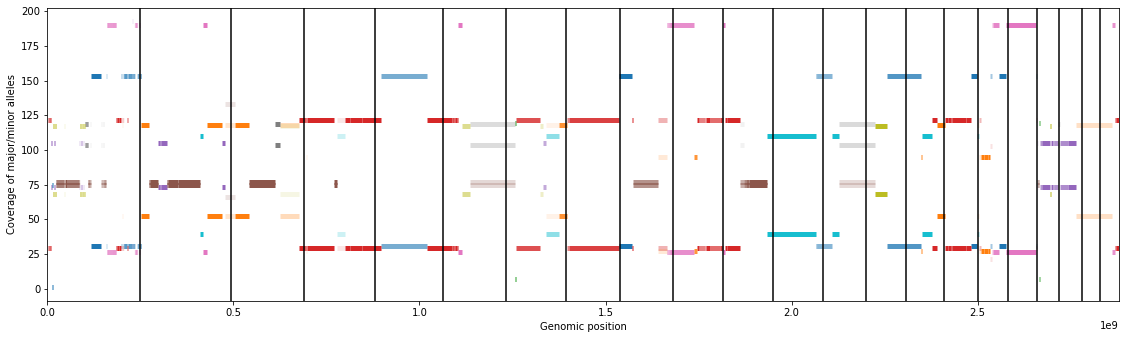

In [54]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
for i, p in enumerate(Pi.T):
    nzidx = p > 0.3
    x = Cov_overlap.loc[:, ["start_g", "next_g"]].loc[nzidx]
    for j, (_, st, en), clust_prob in zip(np.where(nzidx > 0)[0], x.itertuples(), p[nzidx]):
        plt.plot(
            np.r_[st, en],
            np.exp(mcmc_C.mu[i])*f_prune[i]*np.r_[1, 1],
            color = np.array(colors)[i % len(colors)],
            linewidth = 5,
            alpha = clust_prob**2,
            solid_capstyle = "butt"
        )
        plt.plot(
            np.r_[st, en],
            np.exp(mcmc_C.mu[i])*(1 - f_prune[i])*np.r_[1, 1],
            color = np.array(colors)[i % len(colors)],
            linewidth = 5,
            alpha = clust_prob**2,
            solid_capstyle = "butt"
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
#plt.ylim([0, 300]);
plt.show(6)

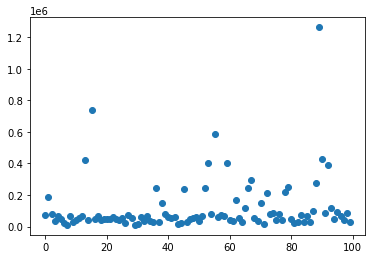

In [59]:
plt.scatter(np.r_[:100], r[:100])

In [70]:
np.argmax(Pi.T, axis=0)[14:45]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3])

In [75]:
Pi.T[:,14:45]

array([[0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.194     , 0.194     , 0.194     , 0.10060362,
        0.10060362, 0.10060362, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
      

In [49]:
[np.array(st, 0) for st, ed in np.array(mcmc_C.F).reshape(-1,2)]

array([[   0,    1],
       [   2,    3],
       [   3,    4],
       ...,
       [1004, 1005],
       [1005, 1006],
       [1006, 1007]])

In [48]:
lc(np.c_[np.zeros(955), np.array(mcmc_C.F).reshape(-1,2)].shape)

ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape ().